# Поедем делать итоговый ансамбль

In [1]:
#base
import os, sys
import datetime
import numpy as np
import pandas as pd
import re
import json
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
from collections import Counter
from collections import OrderedDict
from bs4 import BeautifulSoup
#requests block
import bs4
import requests
#text
import pymorphy2
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
# nltk.download('words')
# nltk.download('brown')
# nltk.download('reuters')
from nltk.corpus import words, brown, reuters
#preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
#classifiers
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#validation
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#pipeline block
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
#visuals
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

In [2]:
def re_domain_for_scrap(url):
    result = re.match(r'(http[s]?://)+(www.)?([^/]*)', url)[0].replace('http://http','http')
    if result is not None: return result
    if result is None : return None

def load_user_json(user_jsons):
    return user_jsons.map(json.loads)  


def token_all(text):
    result=[]
    text = re.sub('[^а-яА-Яa-zA-Z]', ' ', text)
    text = re.sub('https', ' ', text)
    text = re.sub('http', ' ', text)
    text = re.sub('www', ' ', text)    
    result += text.lower().split()
    return result

def fake_tokenizer(text):
    return text
    
def report4(pipeline, X_train, X_test, y_train, y_test, tags, target):

    predicts_prob = pipeline.predict_proba(X_test)
    predicts = pipeline.predict(X_test)
    proba = pd.Series([max(predicts_prob[i]) for i in range(len(predicts_prob))])
    proba_diff = pd.Series([(sorted(predicts_prob[i],reverse=True)[0]-sorted(predicts_prob[i],reverse=True)[1]) 
                            for i in range(len(predicts_prob))])
    out = pd.DataFrame()
    out['y'] = y_test.reset_index()[target]
    out['pred'] = predicts
    out['prob'] = proba
    out['prob_diff'] = proba_diff
    out['correct'] = out.y==out.pred
    out['weight_prob'] = np.log(out.prob_diff/out.prob)
    print('accuracy %s' % accuracy_score(predicts, y_test))
    print('prob_cut_accuracy %s' % out[out.prob>=out['prob'].median()].correct.mean())
    print('prob_diff_cut_accuracy %s' % out[out.prob_diff>=out['prob_diff'].median()].correct.mean())
    print('prob_log_diff_cut_accuracy %s' % out[out.weight_prob>=out['weight_prob'].median()].correct.mean())
    
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

In [3]:
%%time
file_path = '/data/share/project01/gender_age_dataset.txt'
raw_data = pd.read_csv(file_path, sep='\t')

CPU times: user 7.89 s, sys: 6.79 s, total: 14.7 s
Wall time: 14.7 s


In [4]:
%%time
df=raw_data.copy()
#aggregate fields
df['user_json'] = load_user_json(df['user_json'])
df['url_list'] = df['user_json'].map(lambda x: [visit['url'] for visit in x['visits']])
df['class'] = df.gender + ' ' + df.age

CPU times: user 17.6 s, sys: 7.84 s, total: 25.4 s
Wall time: 25.5 s


# Подготовка данных для первой модели:

In [5]:
df['domain'] = df['url_list'].map(lambda x: [re_domain_for_scrap(url) for url in x])

# Done

# Подготовка для второй модели - scrapped from domain data

In [6]:
scrap_dict_headers_file = "scrap_dict_headers.pickle"
scrap_dict_text_file = "scrap_text_headers.pickle"
scrap_dict_headers = pickle.load(open(scrap_dict_headers_file, 'rb'))
scrap_dict_text = pickle.load(open(scrap_dict_text_file, 'rb'))

Загрузили заранее сформированные словари

In [7]:
def apply_scrap_dict_text(urls, domain_dict=scrap_dict_text):
    result=[]
    for url in urls:
        try: result.append(' '.join(domain_dict[url]))
        except: pass
    return ' '.join(result).split()
def apply_scrap_dict_headers(urls, domain_dict=scrap_dict_headers):
    result=[]
    for url in urls:
        try: result.append(' '.join(domain_dict[url]))
        except: pass
    return ' '.join(result).split()

In [21]:
%%time
df['scrap_text'] = df.domain.map(set).map(apply_scrap_dict_text)
df['scrap_headers'] = df.domain.map(set).map(apply_scrap_dict_headers)

CPU times: user 11.7 s, sys: 3.83 s, total: 15.5 s
Wall time: 15.6 s


# Done

# Подготовка данных для третьей модели - url data

In [9]:
%%time
df['url_set'] = df.url_list.map(set)

CPU times: user 2.45 s, sys: 88 ms, total: 2.54 s
Wall time: 2.53 s


In [10]:
super_rus_dict_file = "super_rus_dict.pickle"
super_rus_dict = pickle.load(open(super_rus_dict_file, 'rb'))
super_corp_dict_file = "super_corp_dict.pickle"
super_corp_dict = pickle.load(open(super_corp_dict_file, 'rb'))

In [11]:
total_corp_dict = super_corp_dict
total_corp_dict.update(super_rus_dict)

Загружаем и объединяем словари - да, постоянно забывал спиклить общий словарь =(

In [12]:
def total_nf_from_dict(text):
    result=[]
    for word in text:
        try: result.append(total_corp_dict[word])
        except: pass
    return result

def token_all_urls(url_lst):
    text=' '.join(url_lst)

    text = re.sub('[^а-яА-Яa-zA-Z]', ' ', text)
    text = re.sub('https', ' ', text)
    text = re.sub('http', ' ', text)
    text = re.sub('www', ' ', text)    

    return text.lower().split()

In [13]:
df['tokenized'] = df.url_set.progress_map(token_all_urls)

100%|██████████| 41138/41138 [00:31<00:00, 1313.77it/s]


In [14]:
df['words'] = df.tokenized.progress_map(total_nf_from_dict)

100%|██████████| 41138/41138 [00:13<00:00, 3134.86it/s]


# Done

# Обучение

In [23]:
df1=df[df.gender!='-']
features = ['scrap_text', 'domain', 'words']
target='class'
target1='gender'
target2='age'

In [38]:
train_target=target
X_train, X_test, y_train, y_test = train_test_split(df1[features], 
                                                    df1[train_target], 
                                                    test_size=0.001, 
                                                    random_state=42)
#вот прямо на этих параметрах сплита получил 0.40133. Случайность, на самом деле ¯\_(ツ)_/¯

scrap_text = Pipeline([
                ('selector', TextSelector(key='scrap_text')), 
                ('tfidf', TfidfVectorizer(tokenizer=fake_tokenizer, max_df=0.8, ngram_range=(1,1),
                                      lowercase=False, binary=True, use_idf=False, min_df=10))
            ])
domain = Pipeline([
                ('selector', TextSelector(key='domain')),
                ('tfidf', TfidfVectorizer(tokenizer=fake_tokenizer, ngram_range=(1,1),
                                      lowercase=False, binary=True, use_idf=False, min_df=10, max_df=0.5))
            ])
words = Pipeline([
                ('selector', TextSelector(key='words')),
                ('tfidf', TfidfVectorizer(tokenizer=fake_tokenizer, ngram_range=(1,1),
                                      lowercase=False, binary=True, use_idf=False, min_df=10, max_df=0.5))
            ])

pipeline1 = Pipeline([
    ('features', words),
    ('clf', MultinomialNB(alpha=0.2))])
pipeline2 = Pipeline([
    ('features', scrap_text),
    #('clf', MultinomialNB(alpha=0.2))])
    ('clf', LogisticRegression(max_iter=300, solver='saga'))])
pipeline3 = Pipeline([
    ('features', domain),
    ('clf', MultinomialNB(alpha=0.2))])
estimators = [('pipe1', pipeline1), ('pipe2', pipeline2), ('pipe3', pipeline3)] 

sclf = StackingClassifier(estimators=estimators,
                          final_estimator=LogisticRegression(max_iter=300, solver='saga', C=1.5))

sclf.fit(X_train, y_train)

tags=df1[train_target].unique()
report4(sclf, X_train, X_test, y_train, y_test, tags, train_target)

accuracy 0.35135135135135137
prob_cut_accuracy 0.42105263157894735
prob_diff_cut_accuracy 0.47368421052631576
prob_log_diff_cut_accuracy 0.47368421052631576


# Кривая (пере)обучения

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/opt/anaconda/envs/bd9/l

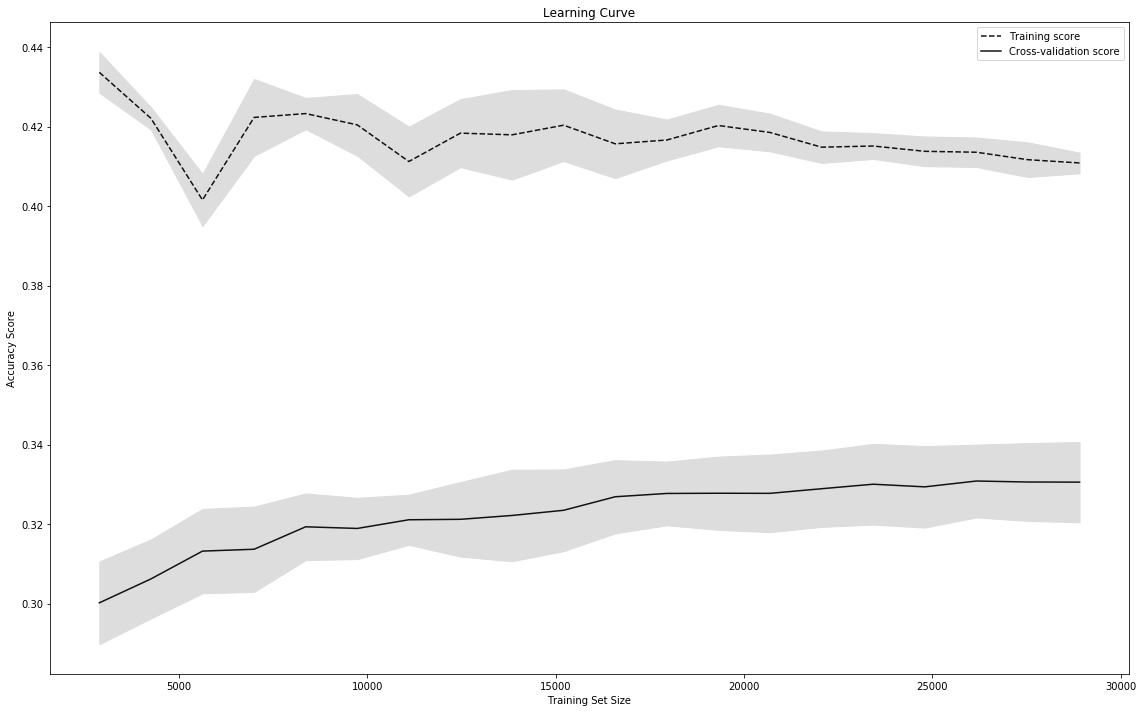

In [37]:
train_sizes, train_scores, test_scores = learning_curve(sclf, 
                                                        df1[features], 
                                                        df1[train_target],
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 20))

def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(16,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
plot_learning_curve(train_sizes, train_scores, test_scores)

In [44]:
# model_file = "3_est_scrap_40_outliers_project01_model.pickle"

# with open(os.environ['HOME'] + '/' + model_file, 'wb') as f:
#     pickle.dump(sclf, f)
    
# os.chmod(os.environ['HOME'] + '/' + model_file, 0o644)

In [3]:
!tail -n1000 /data/share/project01/gender_age_dataset.txt | ./project01_gender-age.py > output.json

./project01_gender-age.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  output.sort_values(by='uid',axis = 0, ascending = True, inplace = True)


<img src="https://getupmag.ru/wp-content/uploads/2019/02/1477647840195420605.jpg" width=600 height=600 />